In [1]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import h5py

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import autocorr_mat, get_lagplot

In [5]:
exp_name = "paul_20250914"
# data_path = f"{paths['livingstone_lab']}/Data/Data-Formatted/{exp_name}_experiment.mat"
# d = loadmat(data_path)
mua_path = "/Volumes/LivingstoneLab/Data/Data-Neuropixels-Preprocessed/paul_250914/catgt_paul_250914_g0/paul_250914_g0_imec0/paul_250914-imec0-mua_cont.h5"


In [ ]:
with h5py.File(mua_path, "r") as f:
    print(list(f.keys()))
    print(f["mua_cont"].shape)  # (1262371, 64)
    #print(f["unit_names"][:])  # convert with array.astype(int)
    mua_cont = f["mua_cont"][:]
 

['mua_cont', 'mua_cont-meta']
(1267347, 383)


In [9]:
mua_cont.shape

(1267347, 383)

In [4]:
print(data_path)

/Volumes/LivingstoneLab/Data/Data-Formatted/paul_20250914_experiment.mat


In [4]:
print(d.keys())  # each of these is a different "dataset" (e.g. Trials, Stimuli)
trials = d["Trials"]
field_names = trials.dtype.names
print(field_names)
# then index like a matlab struct trials[4]["success"]

dict_keys(['__header__', '__version__', '__globals__', 'Session', 'Trials', 'Stimuli', 'config', '__function_workspace__'])
('start_time', 'stop_time', 'success', 'error_code', 'photodiode_flip_times', 'events_matched', 'event_words', 'event_times', 'eye_data_sample_interval', 'eye_data', 'fixation_point', 'user_vars', 'images', 'eye_data_clip_mask', 'fixation_positions', 'fixation_times', 'saccade_times')


In [5]:
rasters_path = f"{paths['livingstone_lab']}/Data/Data-Formatted/{exp_name}-rasters.h5"
with h5py.File(rasters_path, "r") as f:
    print(list(f.keys()))
    print(f["rasters"].shape)  # (1262371, 64)
    print(f["unit_names"][:])  # convert with array.astype(int)
    rasters = f["rasters"][:]

['file_versions', 'rasters', 'unit_names']
(1262371, 64)
[b'1' b'2' b'3' b'4' b'5' b'6' b'7' b'8' b'9' b'10' b'11' b'12' b'13'
 b'14' b'15' b'16' b'17' b'18' b'19' b'20' b'21' b'22' b'23' b'24' b'25'
 b'26' b'27' b'28' b'29' b'30' b'31' b'32' b'33' b'34' b'35' b'36' b'37'
 b'38' b'39' b'40' b'41' b'42' b'43' b'44' b'45' b'46' b'47' b'48' b'49'
 b'50' b'51' b'52' b'53' b'54' b'55' b'56' b'57' b'58' b'59' b'60' b'61'
 b'62' b'63' b'64']


In [6]:
rasters.shape

(1262371, 64)

In [7]:
stimuli = d["Stimuli"]
print(stimuli.dtype.names)

('trial_number', 'serial_number', 'start_time', 'stop_time', 'latency', 'position', 'size_px', 'filename', 'subdir')


In [8]:
stimuli_names = np.concatenate(np.unique(stimuli["filename"]))
stimuli_names = [
    x[:] for x in stimuli_names
]  # because we have to take all the chars in the element
print(stimuli_names)

['anna1_10s.mp4', 'anna1_10s_rev.mp4', 'anna1_to_guy1_10s.mp4', 'anna1_to_guy1_10s_rev.mp4', 'anna1_to_roscoe_10s.mp4', 'anna2_to_marge_10s.mp4', 'anna2_to_marge_10s_rev.mp4', 'rubin2_to_girl1_10s.mp4', 'rubin2_to_girl1_10s_rev.mp4', 'rubin2a_10s.mp4', 'rubin2a_rev.mp4', 'rubin_to_venus_10s.mp4', 'rubin_to_venus_10s_rev.mp4']


In [9]:
s = np.concatenate(stimuli["filename"])
file_list = [str(x[0]) for x in s]

In [ ]:
final_res = {name : [] for name in stimuli_names}
len_window_firing_rate = 1000 / 30  # in ms

# correctly estimates trials durations
for idx, fn in enumerate(file_list):  # range(len(stimuli)): 
    # print(stimuli[idx]["trial_number"],stimuli[idx]["trial_number"].shape)
    trial_number = (
        int(stimuli[idx]["trial_number"][0].item()) - 1
    )  # extracts the trial number to which the stimulus corresponds (-1 because of python indexing)
    
    if trials[trial_number]["success"] == 1 and stimuli[idx]["filename"] == fn:
        trial_start = stimuli[idx]["start_time"][0].item()
        trial_end = stimuli[idx]["stop_time"][0].item()
        trial_duration = trial_end - trial_start
        stim_onset_delay = trial_start - trials[trial_number]["start_time"][0].item()
        # print(stim_onset_delay, stim_onset_delay.shape )
        stim_onset_delay = int(stim_onset_delay) - 1  # -1 for python indexing
        gaze_signal = trials[trial_number]["eye_data"][0]
        end_gaze = min(stim_onset_delay + int(trial_duration), len(gaze_signal))
        # extracts gaze from the stimulus onset till the end of the trial
        gaze_signal = gaze_signal[stim_onset_delay:end_gaze, :]
        trial_start_int = int(trial_start)
        trial_end_int = int(trial_end)
        bins = np.round(np.arange(0, trial_duration, len_window_firing_rate)).astype(
            int
        )  # bins the target trial with the required resolution, convert to int for later indexing
        bins = np.append(bins, int(trial_duration))  # adds the last time bin
        neural_signal = rasters[
            trial_start_int:trial_end_int, :
        ]  # slices the trial from raster
        trial_firing_rate = []

        # the last el in bin is just the end of the trial, that's why the [:-1] indexing
        for idx_bin, bin_start in enumerate(bins[:-1]):
            bin_end = bins[idx_bin + 1]
            curr_chunk = neural_signal[bin_start:bin_end, :]  # slices the current chunk
            curr_firing_rate = np.mean(
                curr_chunk, axis=0
            )  # computes the mean firing rate over the chunk
            trial_firing_rate.append(curr_firing_rate)
        # end for idx, bin_start in enumerate(bins[:-1]):
        trial_firing_rate = np.stack(trial_firing_rate)
        final_res[fn].append(trial_firing_rate)
    # if trials[trial_number]["success"] == 1 and stimuli[idx]["filename"] == fn:
# end for i in range(len(stimuli)):

(10017, 64) 10016.300000000017 150290.775 160307.075 12
(10017, 64) 10016.474999999977 270855.65 280872.125 21
(10050, 64) 10049.800000000047 454936.5 464986.30000000005 30


In [53]:
for idx, fn in enumerate(stimuli_names):
    print(fn, len(final_res[fn]))

anna1_10s.mp4 3
anna1_10s_rev.mp4 1
anna1_to_guy1_10s.mp4 1
anna1_to_guy1_10s_rev.mp4 3
anna1_to_roscoe_10s.mp4 5
anna2_to_marge_10s.mp4 3
anna2_to_marge_10s_rev.mp4 2
rubin2_to_girl1_10s.mp4 2
rubin2_to_girl1_10s_rev.mp4 2
rubin2a_10s.mp4 2
rubin2a_rev.mp4 5
rubin_to_venus_10s.mp4 2
rubin_to_venus_10s_rev.mp4 1


In [ ]:
a = final_res["anna2_to_marge_10s.mp4"]


[a[i].shape[0] for i in range(len(a))]


[301, 301, 301]

In [59]:
for name in stimuli_names:
    print(name)
    min_time_pts = min([final_res[name][i].shape[0] for i in range(len(final_res[name]))])
    for i in range(len(final_res[name])):
        final_res[name][i] = final_res[name][i][:min_time_pts, :]
    final_res[name] = np.stack(final_res[name], axis=2)

anna1_10s.mp4
anna1_10s_rev.mp4
anna1_to_guy1_10s.mp4
anna1_to_guy1_10s_rev.mp4
anna1_to_roscoe_10s.mp4
anna2_to_marge_10s.mp4
anna2_to_marge_10s_rev.mp4
rubin2_to_girl1_10s.mp4
rubin2_to_girl1_10s_rev.mp4
rubin2a_10s.mp4
rubin2a_rev.mp4
rubin_to_venus_10s.mp4
rubin_to_venus_10s_rev.mp4


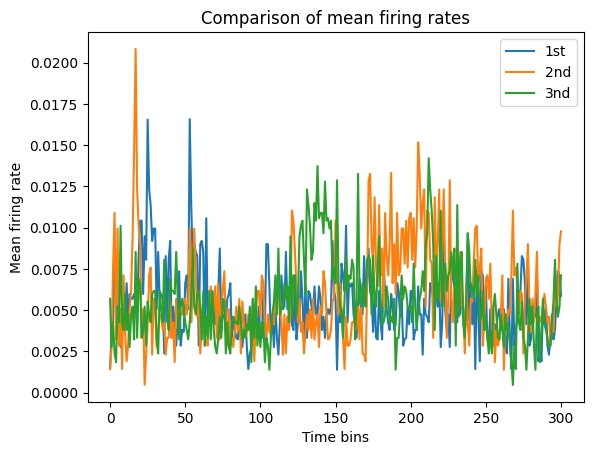

In [71]:
plt.plot(np.mean(final_res["anna2_to_marge_10s.mp4"][:, :, 0], axis=1), label="1st")
plt.plot(np.mean(final_res["anna2_to_marge_10s.mp4"][:, :, 1], axis=1), label="2nd")
plt.plot(np.mean(final_res["anna2_to_marge_10s.mp4"][:, :, 2], axis=1), label="3nd")
plt.legend()
plt.xlabel("Time bins")
plt.ylabel("Mean firing rate")
plt.title("Comparison of mean firing rates")
plt.show()

Text(0, 0.5, 'Time bins')

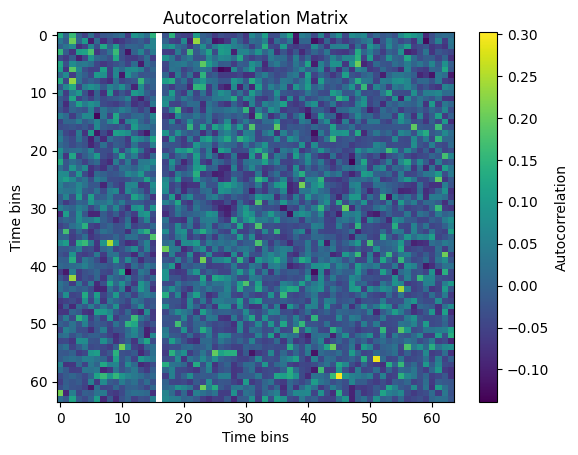

In [85]:
m = autocorr_mat(final_res["anna2_to_marge_10s.mp4"][:, :, 0],final_res["anna2_to_marge_10s_rev.mp4"][:, :, 0][::-1] )
plt.imshow(m, aspect='auto', cmap='viridis')
plt.colorbar(label='Autocorrelation')
plt.title("Autocorrelation Matrix")
plt.xlabel("Time bins")
plt.ylabel("Time bins")

07:46:37 - There are nans in corr_mat


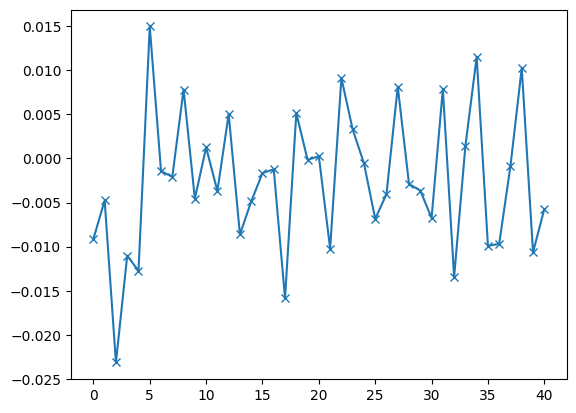

In [84]:
lagplot = get_lagplot(m)
plt.plot(lagplot, marker='x')

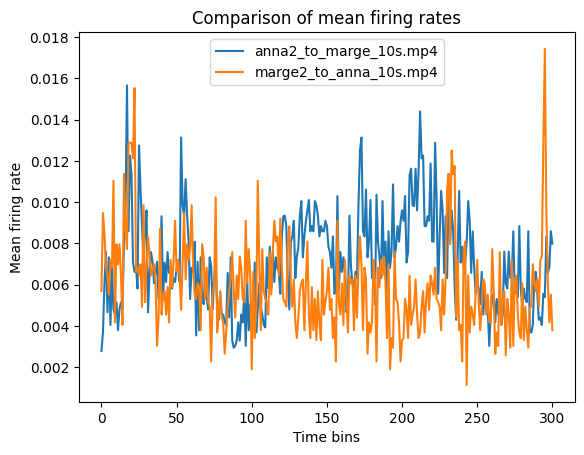

In [ ]:
#fig, axes = plt.subplots(5, 3, figsize=(10, 6))
#plt.plot(anna2_to_marge_10s.mp4")
# plot one video on top of the other inverted
plt.plot(np.mean(final_res["anna2_to_marge_10s.mp4"][:, :40, :], axis=(1, 2)), label="anna2_to_marge_10s.mp4")
plt.plot(np.mean(final_res["anna2_to_marge_10s_rev.mp4"][:, :40, :][::-1], axis=(1, 2)), label="marge2_to_anna_10s.mp4")
plt.legend()
plt.xlabel("Time bins")
plt.ylabel("Mean firing rate")
plt.title("Comparison of mean firing rates")
plt.show()

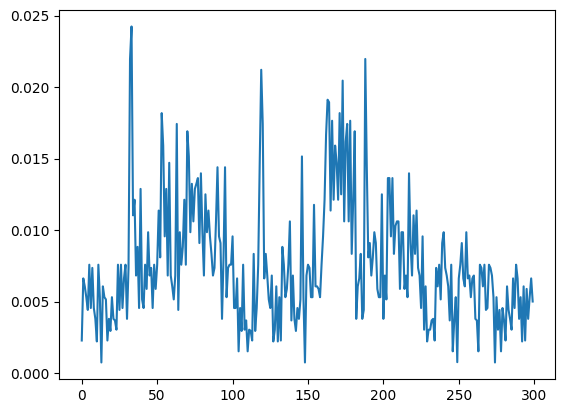

In [193]:
plt.plot(np.mean(trial_firing_rate[:, :40], axis=1))

In [146]:
neural_signal.shape

(9997, 64)

In [ ]:
bins = np.round(np.arange(0, trial_duration, len_window_firing_rate)).astype(int)
print(trial_duration, bins)

[[6182.775]] [   0   33   67  100  133  167  200  233  267  300  333  367  400  433
  467  500  533  567  600  633  667  700  733  767  800  833  867  900
  933  967 1000 1033 1067 1100 1133 1167 1200 1233 1267 1300 1333 1367
 1400 1433 1467 1500 1533 1567 1600 1633 1667 1700 1733 1767 1800 1833
 1867 1900 1933 1967 2000 2033 2067 2100 2133 2167 2200 2233 2267 2300
 2333 2367 2400 2433 2467 2500 2533 2567 2600 2633 2667 2700 2733 2767
 2800 2833 2867 2900 2933 2967 3000 3033 3067 3100 3133 3167 3200 3233
 3267 3300 3333 3367 3400 3433 3467 3500 3533 3567 3600 3633 3667 3700
 3733 3767 3800 3833 3867 3900 3933 3967 4000 4033 4067 4100 4133 4167
 4200 4233 4267 4300 4333 4367 4400 4433 4467 4500 4533 4567 4600 4633
 4667 4700 4733 4767 4800 4833 4867 4900 4933 4967 5000 5033 5067 5100
 5133 5167 5200 5233 5267 5300 5333 5367 5400 5433 5467 5500 5533 5567
 5600 5633 5667 5700 5733 5767 5800 5833 5867 5900 5933 5967 6000 6033
 6067 6100 6133 6167]


/var/folders/nw/yf48zdjj1m5012281wx_pzhc0000gn/T/ipykernel_21826/900913313.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bins = np.round(np.arange(0, trial_duration, len_window_firing_rate)).astype(


/var/folders/nw/yf48zdjj1m5012281wx_pzhc0000gn/T/ipykernel_21826/3373001863.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  np.round(np.arange(


array([   0,   33,   67,  100,  133,  167,  200,  233,  267,  300,  333,
        367,  400,  433,  467,  500,  533,  567,  600,  633,  667,  700,
        733,  767,  800,  833,  867,  900,  933,  967, 1000, 1033, 1067,
       1100, 1133, 1167, 1200, 1233, 1267, 1300, 1333, 1367, 1400, 1433,
       1467, 1500, 1533, 1567, 1600, 1633, 1667, 1700, 1733, 1767, 1800,
       1833, 1867, 1900, 1933, 1967, 2000, 2033, 2067, 2100, 2133, 2167,
       2200, 2233, 2267, 2300, 2333, 2367, 2400, 2433, 2467, 2500, 2533,
       2567, 2600, 2633, 2667, 2700, 2733, 2767, 2800, 2833, 2867, 2900,
       2933, 2967, 3000, 3033, 3067, 3100, 3133, 3167, 3200, 3233, 3267,
       3300, 3333, 3367, 3400, 3433, 3467, 3500, 3533, 3567, 3600, 3633,
       3667, 3700, 3733, 3767, 3800, 3833, 3867, 3900, 3933, 3967, 4000,
       4033, 4067, 4100, 4133, 4167, 4200, 4233, 4267, 4300, 4333, 4367,
       4400, 4433, 4467, 4500, 4533, 4567, 4600, 4633, 4667, 4700, 4733,
       4767, 4800, 4833, 4867, 4900, 4933, 4967, 50

1238377

In [ ]:
fps = 30
t_start = 1 / fps
t_stop = 0.367  # stop in seconds

times = np.arange(t_start, t_stop + 1 / fps, 1 / fps) * 1000  # convert to ms
print(np.round(times))

[ 33.  67. 100. 133. 167. 200. 233. 267. 300. 333. 367. 400.]


In [92]:
for i in range(len(trials)):
    print(trials[i]["success"])

[array([[0]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[1]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[1]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[1]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[1]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[1]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[1]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[1]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[1]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[1]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[1]], dtype=uint8)]
[array([[1]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[0]], dtype=uint8)]
[array([[1]], dtype=